# Cuisine classification

In [1]:
!head sample_submission.csv

Id,cuisine
24888,italian
43564,italian
21898,italian
6991,italian
37700,italian
43546,italian
20544,italian
14160,italian
21405,italian


In [2]:
import json
import random

with open('cooking_train.json') as f:
    trainset = json.load(f)

random.seed(42)
random.shuffle(trainset)
    
print(len(trainset))
print(trainset[:1])

30000
[{'ingredients': ['olive oil', 'garlic cloves', 'black pepper', 'salt', 'polenta', 'fat free less sodium chicken broth', 'chopped onion', 'green cabbage', 'fresh parmesan cheese', 'bay leaf'], 'id': 41682, 'cuisine': 'italian'}]


#### Let's see what labels we have

In [3]:
from collections import Counter
import pandas as pd

labels = [meal['cuisine'] for meal in trainset]

cuisine_counter = Counter(labels)
cuisines_df = pd.DataFrame.from_dict(cuisine_counter, orient='index')

print(cuisines_df)

                 0
brazilian      352
japanese      1076
irish          498
korean         616
chinese       2014
southern_us   3280
british        600
indian        2285
italian       5894
russian        360
thai          1164
vietnamese     620
mexican       4886
cajun_creole  1160
greek          898
french        1983
spanish        741
filipino       564
moroccan       605
jamaican       404


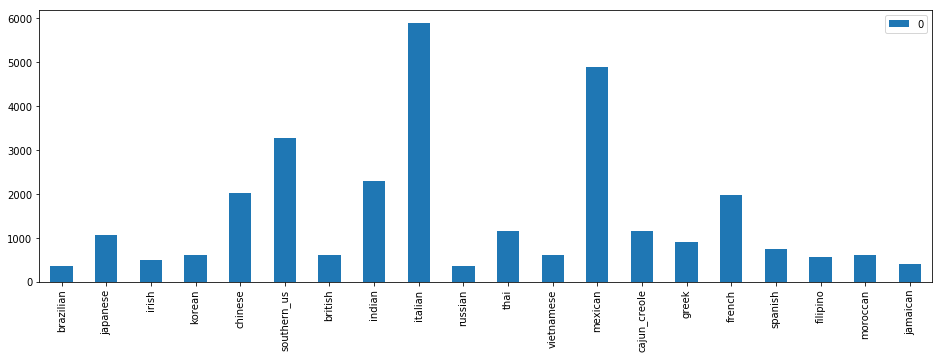

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

cuisines_df.plot(kind='bar', figsize=(16, 5))
plt.show()

### Let's check the list of ingredients

In [5]:
ingredients = []
for meal in trainset:
    ingredients.extend(meal['ingredients'])

ingredients_counter = Counter(ingredients)
ingredients_df = pd.DataFrame.from_dict(ingredients_counter, orient='index')
ingredients_df.columns = ['count']
print(ingredients_df.sort_values(by='count', ascending=False))

                                                    count
salt                                                13681
olive oil                                            6026
onions                                               6024
water                                                5604
garlic                                               5574
sugar                                                4811
garlic cloves                                        4702
butter                                               3684
ground black pepper                                  3591
all-purpose flour                                    3515
pepper                                               3364
vegetable oil                                        3319
eggs                                                 2582
soy sauce                                            2463
tomatoes                                             2323
kosher salt                                          2302
green onions  

# Model 1 - TFIDF on SVC

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import numpy as np

def get_labels(dataset):
    y = np.array([meal['cuisine'] for meal in dataset])
    return y

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, \
AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV

class Vectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, stop_words=None, ngram_range=(1, 1), use_idf=True, max_df=1., min_df=2):
        self.stop_words = stop_words
        self.ngram_range = ngram_range
        self.use_idf = use_idf
        self.max_df = max_df
        self.min_df = min_df
    
    def fit(self, trainset, y=None, **fit_params):
        return self
    
    def transform(self, dataset):
        vectorizer = TfidfVectorizer(stop_words=self.stop_words, ngram_range=self.ngram_range,
                                    use_idf=self.use_idf, max_df=self.max_df, min_df=self.min_df)
        ingredients_lists = [' '.join(meal['ingredients']).lower() for meal in trainset]
        vectorizer.fit(ingredients_lists)
        ingredients_lists = [' '.join(meal['ingredients']).lower() for meal in dataset]
        X = vectorizer.transform(ingredients_lists)
        return X
    
svc_pipeline = Pipeline([
('vectorizer', Vectorizer()),
('classifier', SVC(C=20, gamma=1, class_weight='balanced'))
])

In [8]:
y_train = get_labels(trainset)

In [12]:
from sklearn.model_selection import GridSearchCV
params = {#'vectorizer__use_idf': [False, True],
          #'vectorizer__ngram_range': [(1, 1), (1, 2)],
          #'vectorizer__stop_words': ['english', None]
        #'vectorizer__max_df': [1., 0.95],
        #'vectorizer__min_df': [2, 3],    
        'classifier__C': [20],
        'classifier__gamma': [0.9, 1, 1.1],
        'classifier__class_weight': ['balanced']
}
grid_search = GridSearchCV(estimator=svc_pipeline, param_grid=params, cv=4, verbose=5, n_jobs=8)

In [13]:
grid_search.fit(trainset, y_train)

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] classifier__gamma=0.9, classifier__C=20, classifier__class_weight=balanced 
[CV] classifier__gamma=0.9, classifier__C=20, classifier__class_weight=balanced 
[CV] classifier__gamma=0.9, classifier__C=20, classifier__class_weight=balanced 
[CV] classifier__gamma=0.9, classifier__C=20, classifier__class_weight=balanced 
[CV] classifier__gamma=1, classifier__C=20, classifier__class_weight=balanced 
[CV] classifier__gamma=1, classifier__C=20, classifier__class_weight=balanced 
[CV] classifier__gamma=1, classifier__C=20, classifier__class_weight=balanced 
[CV] classifier__gamma=1, classifier__C=20, classifier__class_weight=balanced 
[CV]  classifier__gamma=0.9, classifier__C=20, classifier__class_weight=balanced, score=0.7985870434550787, total= 5.2min
[CV] classifier__gamma=1.1, classifier__C=20, classifier__class_weight=balanced 
[CV]  classifier__gamma=0.9, classifier__C=20, classifier__class_weight=balanced, score=0.7971188

[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:  8.5min remaining: 25.5min


[CV] classifier__gamma=1.1, classifier__C=20, classifier__class_weight=balanced 
[CV]  classifier__gamma=0.9, classifier__C=20, classifier__class_weight=balanced, score=0.7961359093937375, total= 5.3min
[CV] classifier__gamma=1.1, classifier__C=20, classifier__class_weight=balanced 
[CV]  classifier__gamma=1, classifier__C=20, classifier__class_weight=balanced, score=0.7983193277310925, total= 5.6min
[CV]  classifier__gamma=1, classifier__C=20, classifier__class_weight=balanced, score=0.7981871500933084, total= 5.6min


[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:  8.9min remaining:  8.9min


[CV]  classifier__gamma=1, classifier__C=20, classifier__class_weight=balanced, score=0.7993596584845251, total= 5.7min
[CV]  classifier__gamma=1, classifier__C=20, classifier__class_weight=balanced, score=0.7977348434377082, total= 5.7min
[CV]  classifier__gamma=1.1, classifier__C=20, classifier__class_weight=balanced, score=0.7984537456678219, total= 3.6min


[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed: 13.8min remaining:  4.6min


[CV]  classifier__gamma=1.1, classifier__C=20, classifier__class_weight=balanced, score=0.7974683544303798, total= 3.7min
[CV]  classifier__gamma=1.1, classifier__C=20, classifier__class_weight=balanced, score=0.7991196478591437, total= 3.6min
[CV]  classifier__gamma=1.1, classifier__C=20, classifier__class_weight=balanced, score=0.7969583778014941, total= 3.6min


[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed: 13.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed: 13.9min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', Vectorizer(max_df=1.0, min_df=2, ngram_range=(1, 1), stop_words=None,
      use_idf=True)), ('classifier', SVC(C=20, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'classifier__gamma': [0.9, 1, 1.1], 'classifier__class_weight': ['balanced'], 'classifier__C': [20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [15]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7984
{'classifier__gamma': 1, 'classifier__class_weight': 'balanced', 'classifier__C': 20}


In [16]:
svc_pipeline.fit(trainset, y_train)
y_pred = svc_pipeline.predict(trainset)

In [17]:
with open('cooking_test.json') as f:
    testset = json.load(f)

In [18]:
y_test = svc_pipeline.predict(testset)

In [19]:
ids = [item['id'] for item in testset]
results = pd.DataFrame.from_dict({'Id': ids, 'cuisine': y_test})
print(results.head())

      Id   cuisine
0  24888   italian
1  43564  moroccan
2  21898   italian
3   6991  moroccan
4  37700   spanish


In [20]:
with open('my_submission.csv', 'w') as res:
    results.to_csv(res, index=False)

In [21]:
!head my_submission.csv

Id,cuisine
24888,italian
43564,moroccan
21898,italian
6991,moroccan
37700,spanish
43546,southern_us
20544,chinese
14160,italian
21405,irish


## Simple ensembling - voting classifier

In [76]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, \
AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
    
ensembling_pipeline = Pipeline([
('vectorizer', Vectorizer()),
('classifier', VotingClassifier(estimators =
                                [('svc', SVC(C=20, gamma=1, class_weight='balanced', probability=True)),
                                 ('linsvc', CalibratedClassifierCV(
                                     LinearSVC(fit_intercept=True, class_weight='balanced'), cv = 2)),
                                  ('et', ExtraTreesClassifier(class_weight='balanced')),
                                ('lr', LogisticRegression())],
                                voting='soft',
                                weights = [0.6, 0.2, 0.2, 0.1]))
])

In [73]:
from sklearn.model_selection import GridSearchCV
params = {'classifier__weights': [[0.6, 0.2, 0.2, 0.1], [0.7, 0.2, 0.1, 0.1], [0.7, 0.1, 0.2, 0.1], 
                                  [0.9, 0.05, 0.05, 0.1], 
                                  [0.75, 0.15, 0.1, 0.1], 
                                  [0.6, 0.2, 0.2, 0.05], [0.7, 0.2, 0.1, 0.05], 
                                  [0.7, 0.1, 0.2, 0.05],  [0.9, 0.05, 0.05, 0.05], [0.75, 0.15, 0.1, 0.05]],
}
grid_search = GridSearchCV(estimator=ensembling_pipeline, param_grid=params, cv=4, verbose=5, n_jobs=8)

In [74]:
grid_search.fit(trainset, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] classifier__weights=[0.6, 0.2, 0.2, 0.1] ........................
[CV] classifier__weights=[0.6, 0.2, 0.2, 0.1] ........................
[CV] classifier__weights=[0.6, 0.2, 0.2, 0.1] ........................
[CV] classifier__weights=[0.6, 0.2, 0.2, 0.1] ........................
[CV] classifier__weights=[0.7, 0.2, 0.1, 0.1] ........................
[CV] classifier__weights=[0.7, 0.2, 0.1, 0.1] ........................
[CV] classifier__weights=[0.7, 0.2, 0.1, 0.1] ........................
[CV] classifier__weights=[0.7, 0.2, 0.1, 0.1] ........................
[CV]  classifier__weights=[0.6, 0.2, 0.2, 0.1], score=0.8060517195414556, total=19.6min
[CV] classifier__weights=[0.7, 0.1, 0.2, 0.1] ........................
[CV]  classifier__weights=[0.6, 0.2, 0.2, 0.1], score=0.8019986675549634, total=19.7min


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed: 22.4min


[CV] classifier__weights=[0.7, 0.1, 0.2, 0.1] ........................
[CV]  classifier__weights=[0.7, 0.2, 0.1, 0.1], score=0.8045854438816316, total=19.7min
[CV] classifier__weights=[0.7, 0.1, 0.2, 0.1] ........................
[CV]  classifier__weights=[0.7, 0.2, 0.1, 0.1], score=0.8048552754435108, total=19.7min
[CV] classifier__weights=[0.7, 0.1, 0.2, 0.1] ........................
[CV]  classifier__weights=[0.6, 0.2, 0.2, 0.1], score=0.8064559156996132, total=19.8min
[CV] classifier__weights=[0.9, 0.05, 0.05, 0.1] ......................
[CV]  classifier__weights=[0.6, 0.2, 0.2, 0.1], score=0.8037620064034151, total=19.9min
[CV] classifier__weights=[0.9, 0.05, 0.05, 0.1] ......................
[CV]  classifier__weights=[0.7, 0.2, 0.1, 0.1], score=0.8032283884738527, total=20.0min
[CV] classifier__weights=[0.9, 0.05, 0.05, 0.1] ......................
[CV]  classifier__weights=[0.7, 0.2, 0.1, 0.1], score=0.8015989340439706, total=20.1min
[CV] classifier__weights=[0.9, 0.05, 0.05, 0.1

[Parallel(n_jobs=8)]: Done  34 out of  40 | elapsed: 116.1min remaining: 20.5min


[CV]  classifier__weights=[0.75, 0.15, 0.1, 0.05], score=0.8036523593708345, total=20.3min
[CV]  classifier__weights=[0.9, 0.05, 0.05, 0.05], score=0.8031212484993998, total=20.5min
[CV]  classifier__weights=[0.9, 0.05, 0.05, 0.05], score=0.8030949839914621, total=20.6min
[CV]  classifier__weights=[0.75, 0.15, 0.1, 0.05], score=0.8055222088835534, total=20.5min
[CV]  classifier__weights=[0.75, 0.15, 0.1, 0.05], score=0.8026648900732845, total=20.7min
[CV]  classifier__weights=[0.75, 0.15, 0.1, 0.05], score=0.8029615795090715, total=20.7min


[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed: 116.8min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', Vectorizer(max_df=1.0, min_df=2, ngram_range=(1, 1), stop_words=None,
      use_idf=True)), ('classifier', VotingClassifier(estimators=[('svc', SVC(C=20, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_...,
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[0.8, 0.1, 0.1, 0.1]))]),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'classifier__weights': [[0.6, 0.2, 0.2, 0.1], [0.7, 0.2, 0.1, 0.1], [0.7, 0.1, 0.2, 0.1], [0.9, 0.05, 0.05, 0.1], [0.75, 0.15, 0.1, 0.1], [0.6, 0.2, 0.2, 0.05], [0.7, 0.2, 0.1, 0.05], [0.7, 0.1, 0.2, 0.05], [0.9, 0.05, 0.05, 0.05], [0.75, 0.15, 0.1, 0.05]]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [75]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.804566666667
{'classifier__weights': [0.6, 0.2, 0.2, 0.1]}


In [77]:
ensembling_pipeline.fit(trainset, y_train)
y_pred = ensembling_pipeline.predict(trainset)

In [78]:
with open('cooking_test.json') as f:
    testset = json.load(f)

In [79]:
y_test = ensembling_pipeline.predict(testset)

In [80]:
ids = [item['id'] for item in testset]
results = pd.DataFrame.from_dict({'Id': ids, 'cuisine': y_test})
print(results.head())

      Id   cuisine
0  24888   italian
1  43564  moroccan
2  21898   italian
3   6991  moroccan
4  37700   spanish


In [81]:
with open('my_ensembling_submission.csv', 'w') as res:
    results.to_csv(res, index=False)

In [82]:
!head my_ensembling_submission.csv

Id,cuisine
24888,italian
43564,moroccan
21898,italian
6991,moroccan
37700,spanish
43546,southern_us
20544,chinese
14160,italian
21405,irish


# Experiments with other features

In [17]:
cuisines = set(meal['cuisine'] for meal in trainset)
ingredients_counts = {cuisine : [] for cuisine in cuisines}
for meal in trainset:
    ingredients_counts[meal['cuisine']].append(len(meal['ingredients']))

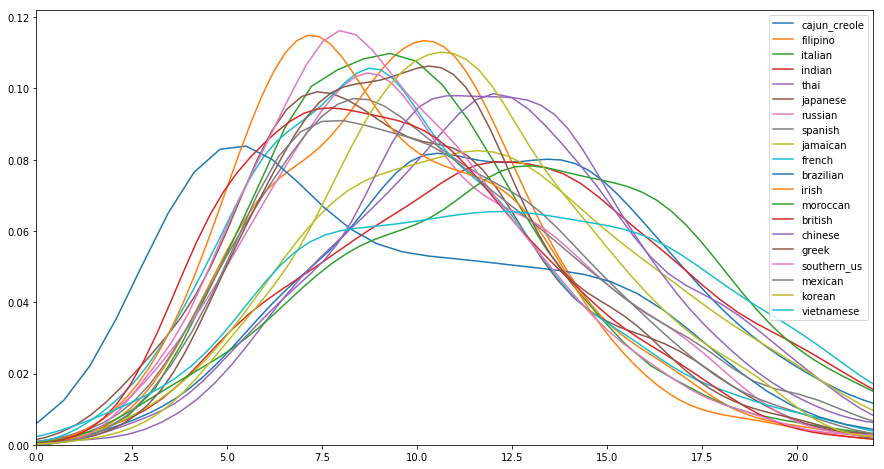

In [18]:
plt.figure(figsize=(15, 8))
plt.xlim(xmax=22)
for label, distr in ingredients_counts.items():
    sns.kdeplot(distr, label=label)
plt.show()

### Adding ingredients count as a feature, did not help here.